## Canine GWAS Variant QC


In [1]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import functools 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os.path as osp
%run ../../nb.py
%run files.py
%run common.py
temp_dir = osp.expanduser('~/data/gwas/tmp/canine')
gab.register_timeop_magic(get_ipython(), 'hail')
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://a783b4e25167:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200212-1019-0.2.30-2ae07d872f43.log


### Reference Data QC

The initial steps in the pipeline will involved loading the NHGRI Dog Genome data and running some basic QC steps, including:
    
- Run call rate filtering
- Group the samples by the 3 most common breeds
- Run MAF and HWE filtering on all variants for each breed separately, and identify variants that pass all filters in all breeds
- Filter the original reference data to the passing variant set
- Run LD pruning
- Remove C/G and A/T SNPs

In [2]:
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

ReferenceGenome(name=canine, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41'], lengths={'1': 122670980, '2': 85416217, '3': 91858198, '4': 88267880, '5': 88908300, '6': 77552613, '7': 80858461, '8': 74057381, '9': 61043804, '10': 69316974, '11': 74388336, '12': 72480470, '13': 63232306, '14': 60959782, '15': 64187680, '16': 59511764, '17': 64281982, '18': 55763074, '19': 53735656, '20': 58114749, '21': 50855586, '22': 61382644, '23': 52291577, '24': 47651928, '25': 51628093, '26': 38939728, '27': 45753342, '28': 41164216, '29': 41841565, '30': 40196606, '31': 39786599, '32': 38745890, '33': 31361794, '34': 42089769, '35': 26506199, '36': 30798114, '37': 30897806, '38': 23903967, '39': 123833839, '41': 6608343}, x_contigs=['39'], y_contigs=[], mt_contigs=['41'], par=[])

In [3]:
mt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_REF_DIR, PLINK_FILE_REF),
    skip_invalid_loci=False, 
    reference_genome='canine'
)
mt.count()

2020-02-11 19:07:02 Hail: INFO: Found 1355 samples in fam file.
2020-02-11 19:07:02 Hail: INFO: Found 150131 variants in bim file.
2020-02-11 19:07:04 Hail: INFO: Coerced sorted dataset


(150131, 1355)

#### Call Rate QC

In [4]:
threshold_call_rate = .96

2020-02-11 19:07:05 Hail: INFO: Coerced sorted dataset
2020-02-11 19:07:13 Hail: INFO: Coerced sorted dataset
2020-02-11 19:07:13 Hail: INFO: Coerced sorted dataset
2020-02-11 19:07:14 Hail: INFO: Coerced sorted dataset
/opt/conda/envs/hail/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10



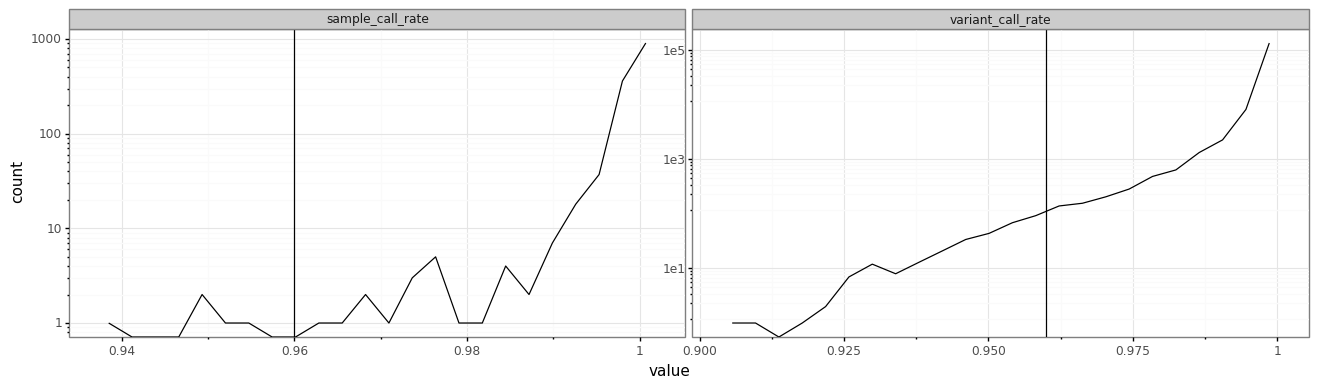

<ggplot: (8747770079049)>

In [5]:
# Find a way to do histogram visualizations for multiple traces (and thresholds) that doesn't involve 
# collecting vectors of size equal to num variants
(
    pn.ggplot(
        pd.concat([
            pd.Series(hl.sample_qc(mt).sample_qc.call_rate.collect())
            .rename('value').to_frame().assign(metric='sample_call_rate'),
            pd.Series(hl.variant_qc(mt).variant_qc.call_rate.collect())
            .rename('value').to_frame().assign(metric='variant_call_rate')
        ]),
        pn.aes(x='value') 
    ) + 
    pn.geom_freqpoly(bins=24) + 
    pn.geom_vline(xintercept=threshold_call_rate) + 
    pn.scale_y_log10() + 
    pn.facet_wrap(' ~ metric', scales='free') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(16, 4))
)

In [6]:
def call_rate_qc(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= threshold_call_rate)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= threshold_call_rate)
    return mt
mt_qc = call_rate_qc(mt)
mt_qc.count()

2020-02-11 19:07:24 Hail: INFO: Coerced sorted dataset
2020-02-11 19:07:31 Hail: INFO: Coerced sorted dataset
2020-02-11 19:07:39 Hail: INFO: Coerced sorted dataset
2020-02-11 19:07:40 Hail: INFO: Coerced sorted dataset


(149845, 1350)

In [7]:
mt_qc.write(osp.join(temp_dir, 'mt_ref_qc_1.mt'), overwrite=True)

2020-02-11 19:07:47 Hail: INFO: Coerced sorted dataset
2020-02-11 19:08:12 Hail: INFO: Coerced sorted dataset
2020-02-11 19:08:19 Hail: INFO: Coerced sorted dataset
2020-02-11 19:08:59 Hail: INFO: wrote matrix table with 149845 rows and 1350 columns in 2 partitions to /tmp/mt_ref_qc_1.mt


#### MAF and HWE QC

This step will involve filtering by reported population/breed much like the UKBB QC process that does this filtering using:

> MAF ≥ 5% and HWE p-value > 10-6 in each of the populations CEU, CHB, JPT and YRI.  

They also specify that the samples selected within each population are "unrelated" but it's unclear whether that means the relatedness was inferred or based on self-reported familial relationships.  We don't have the latter and the specifics of the former aren't given so we will skip that check.

It appears that the 4 populations chosen for this step were intended to represent maximally distance populations within the 1KG data.  Each can be seen here as residing in well isolated clusters ([source](https://www.researchgate.net/figure/Reconstruction-of-population-structure-of-the-1000-Genomes-Project-data-set-A_fig4_320036658)):

<img src="https://www.researchgate.net/publication/320036658/figure/fig4/AS:542940411817984@1506458489974/Reconstruction-of-population-structure-of-the-1000-Genomes-Project-data-set-A.png/">
          
We will try to find similarly distance "clades" (which are analogous to 1KG super populations) within this data and apply HWE/MAF filtering to each. 

In [62]:
# These are the UKBB thresholds for 1KG data (S 2.2)
threshold_hwep, threshold_maf = 10e-6, .05
threshold_hwep, threshold_maf

(1e-05, 0.05)

Attach the breed to the table using sample ids:

In [100]:
mt = hl.read_matrix_table(osp.join(temp_dir, 'mt_ref_qc_1.mt'))

In [117]:
pd.read_excel(osp.join(ORGANISM_CANINE_REF_DIR, '1-s2.0-S2211124717304564-mmc2.xlsx'), sheet_name=0)

,Breed,Abrev.,Clade,Samples,Vayasse-1,Hayward-2,Mizzou-3,Total,COO,BioProject
0,American Cocker Spaniel,ACKR,Spaniel,10.0,NaN,NaN,NaN,10.0,NaN,"GSE90441, GSE96736"
1,American Eskimo Dog,AESK,Nordic Spitz,NaN,NaN,6.0,NaN,6.0,NaN,NaN
2,Afghan Hound,AFGH,Mediterranean,10.0,NaN,NaN,NaN,10.0,NaN,GSE90441
3,American Hairless Terrier,AHRT,American Terrier,10.0,NaN,NaN,NaN,10.0,NaN,GSE96736
4,Airedale Terrier,AIRT,Terrier,3.0,NaN,NaN,NaN,3.0,NaN,GSE96736
...,...,...,...,...,...,...,...,...,...,...
170,* - breeds included in the clade with <50% boo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,"1 - Vaysse A, et al. (2011) Identification of ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,"2 - Hayward JJ, et al. (2016) Complex disease ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,3 - Mizzou Comparative Canine Resequencing: Bi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
df = get_fam(ORGANISM_CANINE_REF_DIR, PLINK_FILE_REF).assign(breed=get_breed)
dfi = get_breed_info(ORGANISM_CANINE_REF_DIR, REF_BREED_INFO_FILE)
assert dfi.groupby('abbr').size().max() == 1
df['breed_name'] = df['breed'].map(dfi.set_index('abbr')['breed'].to_dict())
df['breed_clade'] = df['breed'].map(dfi.set_index('abbr')['clade'].to_dict())
df.head()

,fid,iid,iid_paternal,iid_maternal,sex,pheno,breed,breed_name,breed_clade
0,SALU_CentAsia,SALU_13122,0,0,0,-9,SALU,Saluki,Mediterranean
1,AZWK_Mali,AZWK_15369,0,0,0,-9,AZWK,Azawakh,Mediterranean
2,SALU_CentAsia,SALU_22847,0,0,0,-9,SALU,Saluki,Mediterranean
3,SALU_CentAsia,SALU_22848,0,0,0,-9,SALU,Saluki,Mediterranean
4,AZWK_Mali,AZWK_23339,0,0,0,-9,AZWK,Azawakh,Mediterranean


In [132]:
df['breed'].value_counts()

SALU    19
COOK    10
INCA    10
TIBS    10
SHIH    10
        ..
GWHP     2
CPAT     2
GDJK     2
KOMO     2
MNTY     2
Name: breed, Length: 166, dtype: int64

In [133]:
df['breed_clade'].value_counts()

UK Rural              145
Terrier               140
European Mastiff      139
Mediterranean          98
Asian Spitz            83
Pointer Setter         79
Scent Hound            71
Poodle                 60
Retriever              56
Asian Toy              44
Spaniel                44
Continental Herder     44
Drover                 34
Toy Spitz              32
Alpine                 26
New World              25
Nordic Spitz           24
Schnauzer              20
American Toy           20
American Terrier       16
New World*             15
Small Spitz            14
Pinscher               12
Poodle*                12
NordicSpitz            10
Retriever*             10
Hungarian               9
Pointer Setter*         9
NewWorld*               5
Name: breed_clade, dtype: int64

In [136]:
ht = hl.Table.from_pandas(
    df[['fid', 'iid', 'breed', 'breed_name', 'breed_clade']].fillna('')
    .rename(columns={'fid': 'fam_id', 'iid': 's'})
).key_by('s')
mt = mt.annotate_cols(breed=ht[mt.s].breed, breed_clade=ht[mt.s].breed_clade, breed_name=ht[mt.s].breed_name)
cht = mt.cols()
cht.select(cht.fam_id, cht.breed, cht.breed_name, cht.breed_clade).show(3)

2020-02-12 18:14:34 Hail: INFO: Coerced sorted dataset


s,fam_id,breed,breed_name,breed_clade
str,str,str,str,str
"""ACKR_09007""","""ACKR""","""ACKR""","""American Cocker Spaniel""","""Spaniel"""
"""ACKR_09030""","""ACKR""","""ACKR""","""American Cocker Spaniel""","""Spaniel"""
"""ACKR_09032""","""ACKR""","""ACKR""","""American Cocker Spaniel""","""Spaniel"""


Run PCA to find distance clades for downstream filtering:

In [113]:
pcs = hl.hwe_normalized_pca(mt.GT)[1]

2020-02-12 17:56:39 Hail: INFO: hwe_normalized_pca: running PCA using 149845 variants.
2020-02-12 17:56:45 Hail: INFO: pca: running PCA with 10 components...


In [105]:
# Choose top 4 breeds (analogous to 4 1KG populations)
# TODO: base on PCA results instead
top_breeds = df['breed'].value_counts().sort_values().tail(4).index.tolist()
mts = {br: mt.filter_cols(mt.breed == br) for br in top_breeds}
mts.keys()

dict_keys(['SAMO', 'MALT', 'POM', 'SALU'])

In [106]:
mts[top_breeds[0]].cols().show(3)

s,fam_id,pat_id,mat_id,is_female,is_case,sample_qc.call_rate,sample_qc.n_called,sample_qc.n_not_called,sample_qc.n_filtered,sample_qc.n_hom_ref,sample_qc.n_het,sample_qc.n_hom_var,sample_qc.n_non_ref,sample_qc.n_singleton,sample_qc.n_snp,sample_qc.n_insertion,sample_qc.n_deletion,sample_qc.n_transition,sample_qc.n_transversion,sample_qc.n_star,sample_qc.r_ti_tv,sample_qc.r_het_hom_var,sample_qc.r_insertion_deletion,breed
str,str,str,str,bool,bool,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,str
"""SAMO_00229""","""SAMO""",NA,NA,true,NA,9.96e-01,149229,616,0,90447,37585,21197,58782,0,79979,0,0,61551,18428,0,3.34e+00,1.77e+00,NA,"""SAMO"""
"""SAMO_14507""","""SAMO""",NA,NA,false,NA,1.00e+00,149771,74,0,93461,32065,24245,56310,0,80555,0,0,61937,18618,0,3.33e+00,1.32e+00,NA,"""SAMO"""
"""SAMO_14510""","""SAMO""",NA,NA,false,NA,1.00e+00,149783,62,0,89681,39269,20833,60102,0,80935,0,0,62239,18696,0,3.33e+00,1.88e+00,NA,"""SAMO"""


Visualize HWE and MAF distributions before filtering on them:

In [107]:
df_qc = pd.concat([
        pd.Series(hl.variant_qc(mts[br]).variant_qc.p_value_hwe.collect())
            .rename('value').to_frame().assign(metric='hwep', breed=br)
        for br in mts.keys()
    ] + [
        pd.Series(hl.variant_qc(mts[br]).variant_qc.AF[1].collect())
            .rename('value').to_frame().assign(metric='maf', breed=br)
        for br in mts.keys()
])
df_qc.head()

,value,metric,breed
0,0.5,hwep,SAMO
1,0.5,hwep,SAMO
2,0.5,hwep,SAMO
3,0.5,hwep,SAMO
4,0.5,hwep,SAMO


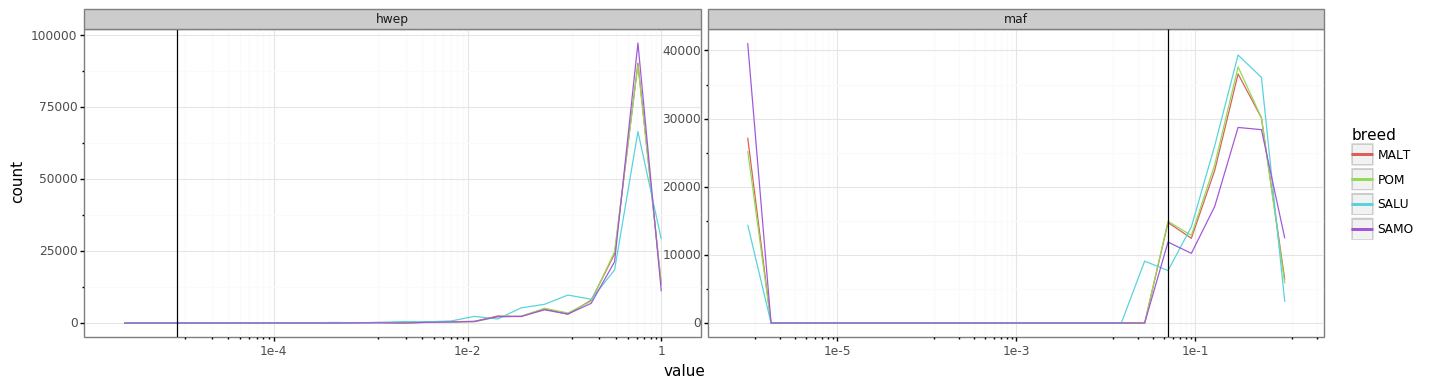

<ggplot: (8732278099821)>

In [108]:
# Note that the AF for the first allele (in mt.alleles) is much closer to 100% while the second is generally far smaller
# (i.e. the convention for this dataset must be A1 = major, A2 = minor which is the opposite of the usual PLINK convention)
# See: https://www.biostars.org/p/90264/
(
    pn.ggplot(df_qc.assign(value=lambda df: df['value'] + 1e-6), pn.aes(x='value', color='breed')) + 
    pn.geom_freqpoly(bins=24) + 
    pn.geom_vline(data=df_qc[df_qc['metric'] == 'hwep'], mapping=pn.aes(xintercept=threshold_hwep)) + 
    pn.geom_vline(data=df_qc[df_qc['metric'] == 'maf'], mapping=pn.aes(xintercept=threshold_maf)) + 
    pn.scale_x_log10() + 
    pn.facet_wrap(' ~ metric', scales='free') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(16, 4))
)

In order to move forward to filtering, we should first verify that alternate alleles are coded correctly.  It would be unlikely for a published dataset to have the allele coding flipped but since this is a non-human organism, it is worth the extra check:

In [109]:
# Check n_alt_alleles = 0 is actually the most common call
hist = mt.aggregate_entries(hl.agg.hist(mt.GT.n_alt_alleles(), 0, 2, 3))
hist

Struct(bin_edges=[0.0, 0.6666666666666666, 1.3333333333333333, 2.0], bin_freq=[123120084, 50201873, 28750884], n_smaller=0, n_larger=0)

In [110]:
cts = pd.Series(hist.bin_freq).rename('count').rename_axis('n_alt_alleles').reset_index()
assert cts.sort_values('count')['n_alt_alleles'].tail(1).values[0] == 0
cts

,n_alt_alleles,count
0,0,123120084
1,1,50201873
2,2,28750884


Now that we know that the alleles array has the order (major, minor) and n_alt_alleles codes for what we want, we can move on to filtering. 

TODO: Investigate [hl.filtering_allele_frequency](https://hail.is/docs/0.2/experimental/index.html?highlight=allele_frequency#hail.experimental.filtering_allele_frequency) for MAF QC since it may be appropriate here with small sample sizes per population

In [111]:
%%time
def hwe_qc(mt, breeds):
    # See https://discuss.hail.is/t/issues-with-sample-and-variant-qc-by-group/1286
    # for a related discussion on this aggregation
    def get_hwe(mt):
        mt = mt.filter_cols(hl.set(breeds).contains(mt.breed))
        # Add HWE as dict<str, float64> (each key is one of the breeds)
        mt = mt.annotate_rows(hwe=hl.agg.group_by(mt.breed, hl.agg.hardy_weinberg_test(mt.GT).p_value))
        return mt
    mtv = get_hwe(mt)
    return mt.filter_rows(mtv.index_rows(mt.row_key).hwe.values().all(lambda x: x > threshold_hwep))

def maf_qc(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.AF[1] > threshold_maf)
    return mt.drop('variant_qc')

mt_qc = mt
print('Shape before filtering:', mt_qc.count())

# Sample size per breed is very small (~10) so HWE p-value filter will 
# have low power but still be normalized by sample size
mt_qc = hwe_qc(mt_qc, top_breeds)
print('Shape after HWE filtering:', mt_qc.count())

# Do MAF filtering across entire population since variance is not 
# accounted for with a naive MAF estimator (and the per-breed sample sizes are tiny)
mt_qc = maf_qc(mt_qc)
print('Shape after MAF filtering:', mt_qc.count())

mt_qc.count()

Shape before filtering: (149845, 1350)
Shape after HWE filtering: (149837, 1350)
Shape after MAF filtering: (140059, 1350)
CPU times: user 208 ms, sys: 12.2 ms, total: 220 ms
Wall time: 17.6 s


(140059, 1350)

In [112]:
mt_qc.write(osp.join(temp_dir, 'mt_ref_qc_2.mt'), overwrite=True)

2020-02-12 17:55:11 Hail: INFO: wrote matrix table with 140059 rows and 1350 columns in 2 partitions to /home/eczech/data/gwas/tmp/canine/mt_ref_qc_2.mt


#### LD Pruning

In [98]:
mt = hl.read_matrix_table(osp.join(temp_dir, 'mt_ref_qc_2.mt'))
mt.count()

(140059, 1350)

In [99]:
# TODO: Investiage what the "wrote table with 0 rows" here means
ht_var = hl.ld_prune(mt.GT, r2=0.2, bp_window_size=1000000)
ht_var.describe()

2020-02-12 17:42:17 Hail: INFO: ld_prune: running local pruning stage with max queue size of 172961 variants
2020-02-12 17:42:25 Hail: INFO: wrote table with 68497 rows in 2 partitions to file:/tmp/hail.gTowFaAec9A0/O75rZoMifh
2020-02-12 17:42:34 Hail: INFO: Wrote all 17 blocks of 68497 x 1350 matrix with block size 4096.
2020-02-12 17:45:03 Hail: INFO: wrote table with 1 row in 33 partitions to file:/tmp/hail.gTowFaAec9A0/9hMv5d2d4p


----------------------------------------
Global fields:
    'variants_to_remove': set<int32> 
----------------------------------------
Row fields:
    'locus': locus<canine> 
    'alleles': array<str> 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [159]:
ht_var.count()

44079

In [156]:
mt_pr = mt.filter_rows(hl.is_defined(ht_var[mt.row_key]))
mt_pr.count()

(44079, 1350)

In [157]:
mt_pr.write('/tmp/mt_ref_qc_3.mt', overwrite=True)

2020-02-11 06:58:32 Hail: INFO: wrote matrix table with 44079 rows and 1350 columns in 2 partitions to /tmp/mt_ref_qc_3.mt


#### Remove C/G and A/T SNPs

In [2]:
mt = hl.read_matrix_table('/tmp/mt_ref_qc_3.mt')
mt.count()

(44079, 1350)

In [3]:
mt.alleles.show(5)

locus,alleles
locus<canine>,array<str>
1:249580,"[""A"",""G""]"
1:348210,"[""T"",""C""]"
1:602567,"[""G"",""A""]"
1:1084288,"[""G"",""A""]"
1:1608626,"[""C"",""G""]"


In [ ]:
# TODO: How do we get a count of these strings then w/o collect + pandas?
# > mt_ac.aggregate_rows(hl.agg.counter(hl.delimit(hl.sorted(mt.alleles))))
# {'A,A,A,G,\x0b\x00\x00': 16111,
#  'A,A,A,G,G,G': 792,
#  'C,C,C,G,G,G': 76,
#  'A,A,A,T,T,T': 66,
#  'C,C,C,T,\x0b\x00\x00': 16171,
#  'C,C,C,G,\x0b\x00\x00': 1315,
#  'G,G,G,T,T,T': 182,
#  'A,A,A,C,\x0b\x00\x00': 3520,
#  'A,A,A,C,C,C': 160,
#  'C,C,C,T,T,T': 825,
#  'A,A,A,T,\x0b\x00\x00': 1399,
#  'G,G,G,T,\x0b\x00\x00': 3462}

In [4]:
# Segfault
# mt.aggregate_rows(hl.agg.counter(hl.sorted(mt.alleles)))

In [4]:
pd.Series(hl.delimit(hl.sorted(mt.alleles), '').collect()).value_counts()

CT    16996
AG    16903
AC     3680
GT     3644
AT     1465
CG     1391
dtype: int64

In [12]:
mt_ac = mt.annotate_rows(astr=hl.delimit(hl.sorted(mt.alleles), ''))
mt_ac.rows().show(3)

locus,alleles,rsid,cm_position,variant_qc.AC,variant_qc.AF,variant_qc.AN,variant_qc.homozygote_count,variant_qc.call_rate,variant_qc.n_called,variant_qc.n_not_called,variant_qc.n_filtered,variant_qc.n_het,variant_qc.n_non_ref,variant_qc.het_freq_hwe,variant_qc.p_value_hwe,astr
locus<canine>,array<str>,str,float64,array<int32>,array<float64>,int32,array<int32>,float64,int64,int64,int64,int64,int64,float64,float64,str
1:249580,"[""A"",""G""]","""chr1_249580""",0.00e+00,"[2248,462]","[8.30e-01,1.70e-01]",2710,"[997,104]",1.00e+00,1355,0,0,254,358,2.83e-01,1.20e-29,"""AG"""
1:348210,"[""T"",""C""]","""chr1_348210""",0.00e+00,"[1720,988]","[6.35e-01,3.65e-01]",2708,"[632,266]",9.99e-01,1354,1,0,456,722,4.64e-01,1.07e-23,"""CT"""
1:602567,"[""G"",""A""]","""chr1_602567""",0.00e+00,"[2275,435]","[8.39e-01,1.61e-01]",2710,"[1009,89]",1.00e+00,1355,0,0,257,346,2.70e-01,3.31e-23,"""AG"""


In [ ]:
mt_qc = mt.filter_rows(
    hl.sorted(mt.alleles) != 
)